In [ ]:
# ======================================================
# Predicting Planet Traits & Spotting Unicorn Worlds using Stellar Parents #

## This notebook explores how stellar characteristics influence exoplanet traits (mass and radius) and identifies “unicorn planets”
## —planets that defy the rules of their star. Using our cleaned exoplanet dataset, we will:
## Train ML models (RandomForest/XGBoost) to predict planet mass and radius from stellar features.
## Analyze feature importance to see which stellar properties matter most.
## Examine multi-planet systems to spot correlations between sibling planets.
## Flag unusual planets whose traits do not match predictions as unicorns.
# ======================================================

In [5]:
# Import libraries
!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (from Warehouse folder)
df = pd.read_csv("exoplanets_merged_ml.csv")
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 96.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 88.0 MB/s eta 0:00:0000:0100:01


,rowid,planet_id,star_id,system_id,pl_orbper,pl_rade,pl_masse,pl_name,discoverymethod,disc_year,...,st_rad,st_teff,sy_dist,sy_plx,pl_masse_ml,pl_masse_source,pl_rade_ml,pl_rade_source,pl_masse_filled,pl_rade_filled
0,1.0,3,22541,1,323.21,NaN,NaN,11 Com b,Radial Velocity,2007.0,...,10.86,4841.0,93.18,10.71,1543.67100,ML Estimated,7.086900,ML Estimated,1543.67100,7.086900
1,2.0,3,2,1,326.03,NaN,NaN,11 Com b,Radial Velocity,2007.0,...,19.00,4742.0,93.18,10.71,3690.57760,ML Estimated,7.221600,ML Estimated,3690.57760,7.221600
2,3.0,3,22539,1,NaN,NaN,NaN,11 Com b,Radial Velocity,2007.0,...,NaN,NaN,93.18,10.71,2767.43160,ML Estimated,4.883455,ML Estimated,2767.43160,4.883455
3,4.0,6,2227,2,516.22,NaN,NaN,11 UMi b,Radial Velocity,2009.0,...,10.22,4580.0,125.32,7.95,1701.47485,ML Estimated,5.875700,ML Estimated,1701.47485,5.875700
4,5.0,6,22437,2,516.22,NaN,NaN,11 UMi b,Radial Velocity,2009.0,...,1.45,6397.0,125.32,7.95,1896.82995,ML Estimated,8.521050,ML Estimated,1896.82995,8.521050


R²: -0.2545991190543915
MAE: 436.41612203416986
     feature  importance
3    sy_dist    0.447752
4  pl_orbper    0.191145
2    st_teff    0.144574
0    st_mass    0.116884
5     sy_plx    0.089071
1     st_rad    0.010573


/tmp/ipykernel_1902/348918734.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='magma')


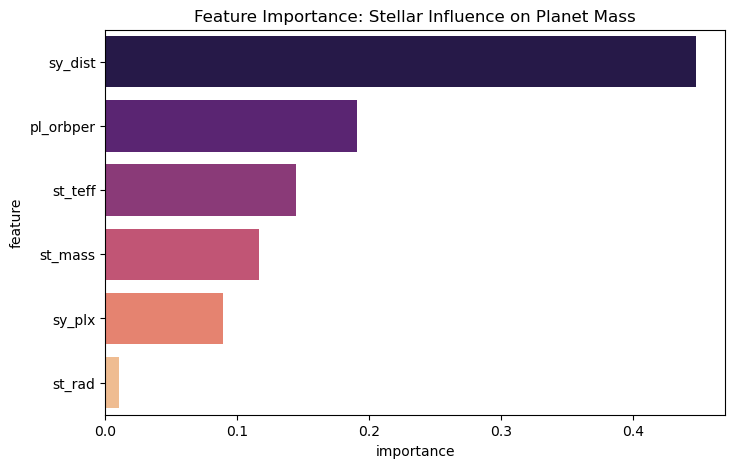

In [25]:
# ===============================
# Stellar Influence on Planet Mass
# ===============================

## We used XGBoost to predict planet mass because it efficiently handles complex,
## non-linear relationships in our exoplanet data and provides clear feature importance metrics, 
## helping us identify which stellar and system properties most influence planet mass. 

# Select features & target
features = ['st_mass', 'st_rad', 'st_teff', 'sy_dist', 'pl_orbper', 'sy_plx'] 
target = 'pl_masse_filled' 


# Prepare training data
train_df = df[df[target].notna()]
X = train_df[features]
y = train_df[target]

# Initialize XGBoost regressor
xgb_mass_model = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.07,     # Step size shrinkage
    max_depth=4,            # Maximum depth of each tree
    random_state=42
)
xgb_mass_model.fit(X, y)

# Evaluate
y_pred = xgb_model.predict(X)
print("R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))

# Feature importance
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
print(importance_df)

# Plot Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=importance_df, palette='magma')
plt.title("Feature Importance: Stellar Influence on Planet Mass")
plt.show()

In [ ]:
## The orbital period, pl_orbper, is the single most important factor influencing planet radius. 
## Planets with longer or shorter orbital periods tend to differ in size.

## Stellar radius, st_rad, affects the planet’s observed radius; bigger stars host bigger planets or affect measurement/formation.

R²: 0.7406850059860213
MAE: 3.532672882790304
     feature  importance
3    sy_dist    0.447752
4  pl_orbper    0.191145
2    st_teff    0.144574
0    st_mass    0.116884
5     sy_plx    0.089071
1     st_rad    0.010573


/tmp/ipykernel_1902/4161239240.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='cividis')


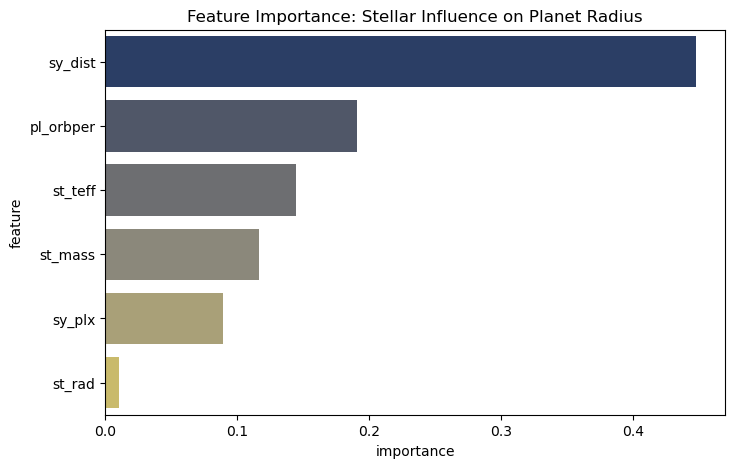

In [26]:
# ===============================
# Stellar Influence on Planet Radius
# ===============================

# Select features & target
features = ['st_mass', 'st_rad', 'st_teff', 'sy_dist', 'pl_orbper', 'sy_plx'] 
target = 'pl_rade_filled' 


# Prepare training data
train_df = df[df[target].notna()]
X = train_df[features]
y = train_df[target]

# Initialize XGBoost regressor
xgb_radius_model = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.07,     # Step size shrinkage
    max_depth=4,            # Maximum depth of each tree
    random_state=42
)
xgb_radius_model.fit(X, y)

# Evaluate
y_pred = xgb_model.predict(X)
print("R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))

# Feature importance
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
print(importance_df)

# Plot Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=importance_df, palette='cividis')
plt.title("Feature Importance: Stellar Influence on Planet Radius")
plt.show()

In [ ]:
## Surprisingly, radius seems more strongly linked to system-level factor, sy_dist, and orbital 
## dynamics than directly to stellar properties in this dataset.

In [28]:
# ===============================
# Unicorn Exoplanets Detection
# ===============================

# Using the trained XGBoost model to predict mass and radius for all planets using only the important features

# Predict expected mass & radius
df['expected_mass'] = xgb_mass_model.predict(df[['st_mass', 'st_rad', 'st_teff', 'sy_dist', 'pl_orbper', 'sy_plx']])
df['expected_radius'] = xgb_radius_model.predict(df[['st_mass', 'st_rad', 'st_teff', 'sy_dist', 'pl_orbper', 'sy_plx']])

# Compute Deviations
df['mass_deviation'] = abs(df['pl_masse_filled'] - df['expected_mass'])
df['radius_deviation'] = abs(df['pl_rade_filled'] - df['expected_radius'])

# Set a Threshold for Unicorns
mass_threshold = df['mass_deviation'].mean() + 2 * df['mass_deviation'].std()
radius_threshold = df['radius_deviation'].mean() + 2 * df['radius_deviation'].std()

df['is_unicorn'] = (df['mass_deviation'] > mass_threshold) | (df['radius_deviation'] > radius_threshold)

In [31]:
## Analyze Unicorn Planets
unicorns = df[df['is_unicorn']]
print(unicorns[['pl_name','pl_masse_filled','pl_rade_filled','expected_mass','expected_radius','mass_deviation','radius_deviation']])

                            pl_name  pl_masse_filled  pl_rade_filled  \
30          1RXS J160929.1-210524 b       3000.00000        54.94605   
36     2MASS J01033563-5515561 AB b       4131.79000        14.63170   
38        2MASS J01225093-2439505 b       7786.50000        14.22645   
39        2MASS J02192210-3925225 b       4417.84000        16.14000   
41        2MASS J03590986+2009361 b       5720.91000        17.63785   
...                             ...              ...             ...   
39154                     ome Ser b       4955.56315         7.48115   
39176                     rho CrB d      10226.71975         4.85890   
39199                     ups And c       4443.24000        13.27770   
39201                     ups And c       2875.28940         4.94660   
39209                      xi Aql b       5626.50690         4.58809   

       expected_mass  expected_radius  mass_deviation  radius_deviation  
30       4273.913086        53.363148     1273.913086        

In [32]:
# Create Unicorn Score
# Sum of deviations in mass and radius
df['unicorn_score'] = df['mass_deviation'] + df['radius_deviation']

# Export unicorn exoplanets CSV
unicorns = df[df['is_unicorn']].copy()
unicorns.to_csv("unicorn_exoplanets.csv", index=False)
print(f"Exported {len(unicorns)} unicorn planets to CSV.")

Exported 1177 unicorn planets to CSV.


/tmp/ipykernel_1902/553970799.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=super_unicorns,


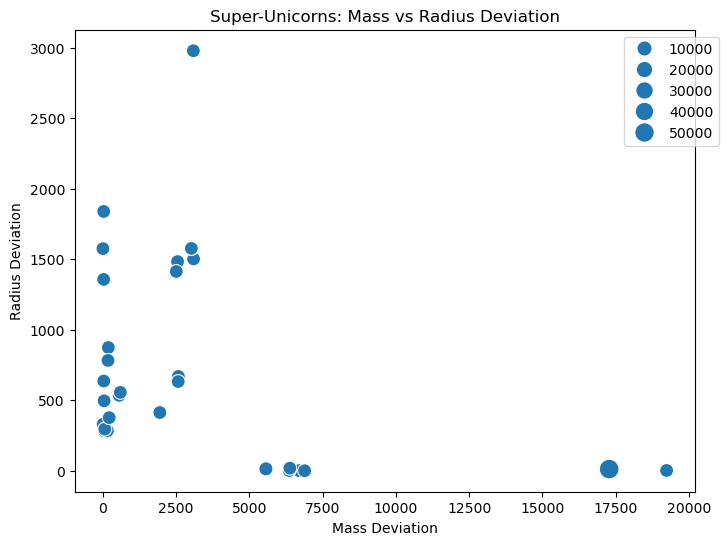

In [50]:
super_unicorns = unicorns[
    (unicorns['mass_deviation'] > mass_thresh) |
    (unicorns['radius_deviation'] > radius_thresh)
]

plt.figure(figsize=(8,6))
sns.scatterplot(data=super_unicorns,
                x='mass_deviation',
                y='radius_deviation',
                size='pl_orbper',
                palette='magma',
                sizes=(100,200))
plt.title("Super-Unicorns: Mass vs Radius Deviation")
plt.xlabel("Mass Deviation")
plt.ylabel("Radius Deviation")
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 Super-Unicorns Table
super_unicorns['unicorn_score'] = super_unicorns['mass_deviation'] + super_unicorns['radius_deviation']
top10_unicorns = super_unicorns.sort_values('unicorn_score', ascending=False).head(10)
print("Top 10 Super-Unicorns:")
print(top10_unicorns[['pl_name','mass_deviation','radius_deviation','pl_orbper','st_mass','unicorn_score']])

Top 10 Super-Unicorns:
                     pl_name  mass_deviation  radius_deviation  pl_orbper  \
35805                  PH2 b    19236.923438          2.525894     282.52   
3698              HD 72659 c    17276.834844         12.257619   51900.00   
35478  OGLE-2014-BLG-0221L b    14078.086914          9.156742        NaN   
35557  OGLE-2016-BLG-1266L b    13838.750898          6.791728        NaN   
35563  OGLE-2016-BLG-1266L b    13838.750898          6.791728        NaN   
6472    KMT-2022-BLG-2286L b    11014.625127         13.132042        NaN   
6368    KMT-2020-BLG-0414L c     8725.082383         12.689263        NaN   
6512    KMT-2024-BLG-0404L b     7718.879004          5.405192        NaN   
35479  OGLE-2014-BLG-0221L b     7473.863086          2.196742        NaN   
6365    KMT-2020-BLG-0414L c     7008.812383          4.428563        NaN   

       st_mass  unicorn_score  
35805     0.94   19239.449331  
3698      0.65   17289.092463  
35478     0.69   14087.243656  
3

/tmp/ipykernel_1902/1387478248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super_unicorns['unicorn_score'] = super_unicorns['mass_deviation'] + super_unicorns['radius_deviation']


/tmp/ipykernel_1902/3970051152.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


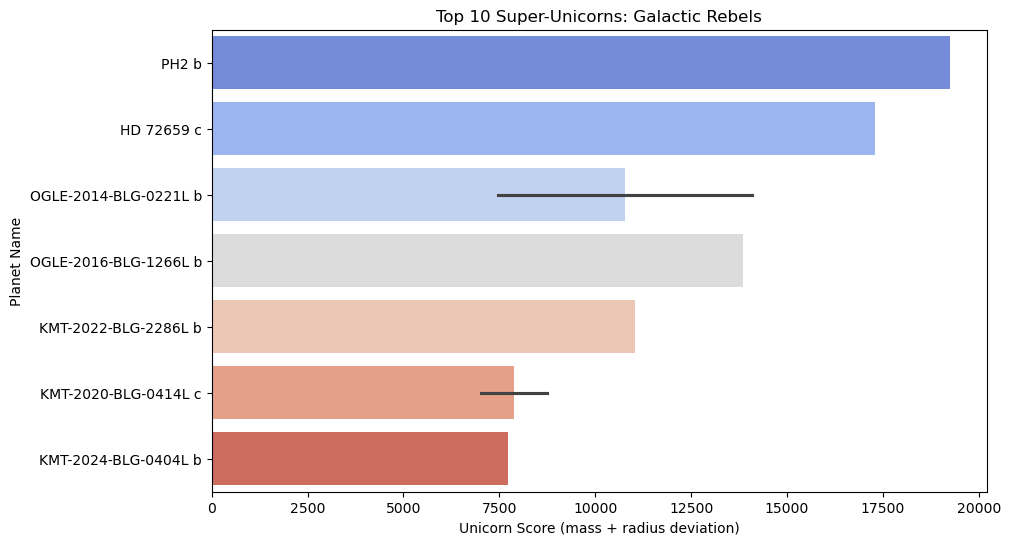

In [60]:
# Super-Unicorns: Top Deviators
# "The Galactic Rebels"
# Highlight the planets with the largest combined deviations in mass and radius.
# ===============================
top10_unicorns = super_unicorns.sort_values('unicorn_score', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x='unicorn_score',
    y='pl_name',
    data=top10_unicorns,
    palette='coolwarm'
)
plt.title("Top 10 Super-Unicorns: Galactic Rebels")
plt.xlabel("Unicorn Score (mass + radius deviation)")
plt.ylabel("Planet Name")
plt.show()

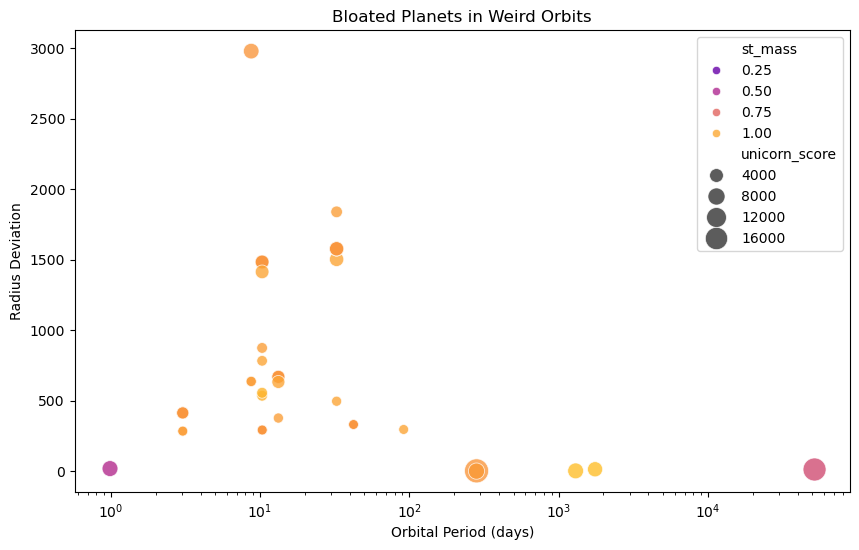

In [69]:
# Orbital Period vs Radius Deviation
# "Bloated Planets in Weird Orbits"
# See which planets are unusually large for their orbital period.
# ===============================
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='pl_orbper',
    y='radius_deviation',
    data=super_unicorns,
    size='unicorn_score',
    hue='st_mass',           # color by stellar mass
    palette='plasma',
    alpha=0.8,
    sizes=(50, 300)
)
plt.title("Bloated Planets in Weird Orbits")
plt.xlabel("Orbital Period (days)")
plt.ylabel("Radius Deviation")
plt.xscale('log')  # orbital periods vary widely
plt.show()

/tmp/ipykernel_1902/3693483154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


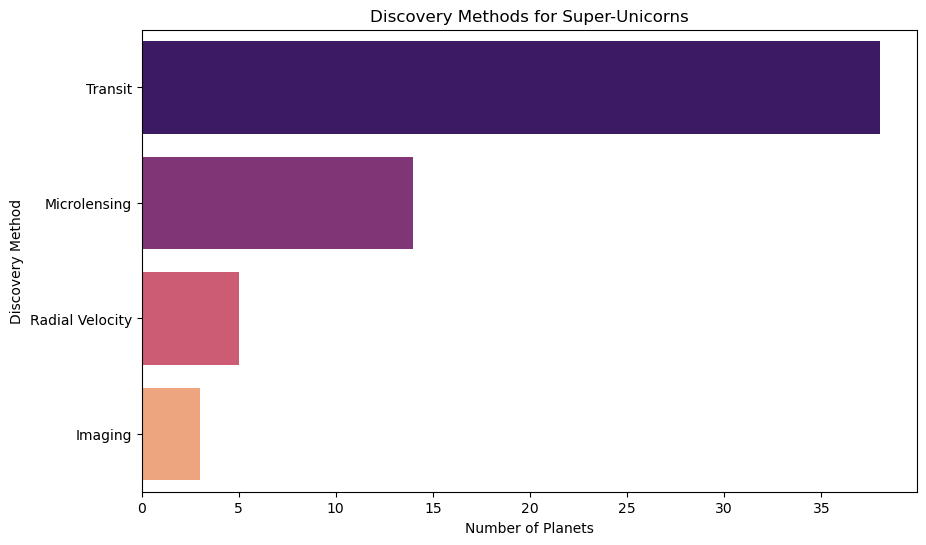

In [65]:
# Count of Super-Unicorns by Discovery Method
# "How Did We Find the Rebels?"
# Bar chart showing how these extreme planets were discovered.
# ===============================
plt.figure(figsize=(10,6))
sns.countplot(
    y='discoverymethod',
    data=super_unicorns,
    order=super_unicorns['discoverymethod'].value_counts().index,
    palette='magma'
)
plt.title("Discovery Methods for Super-Unicorns")
plt.xlabel("Number of Planets")
plt.ylabel("Discovery Method")
plt.show()

/tmp/ipykernel_1902/421336431.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super_unicorns['st_mass_bin'] = pd.cut(super_unicorns['st_mass'], bins=6)
/tmp/ipykernel_1902/421336431.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


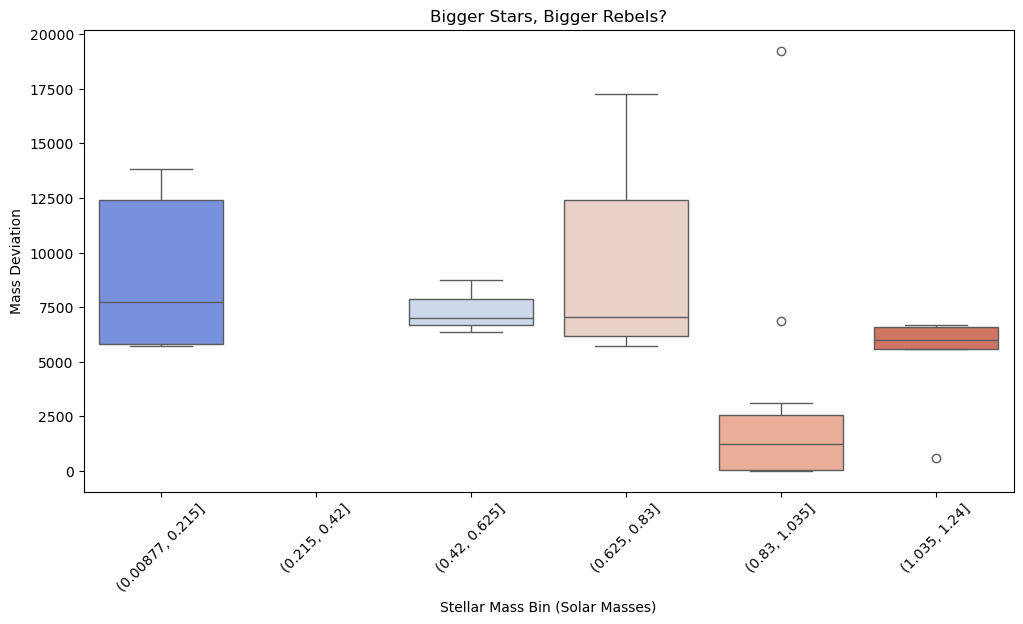

In [70]:
# Stellar Mass vs Mass Deviation
# "Bigger Stars, Bigger Rebels?"
# Boxplot comparing mass deviation across stellar mass bins.
# ===============================
# Create stellar mass bins
super_unicorns['st_mass_bin'] = pd.cut(super_unicorns['st_mass'], bins=6)

plt.figure(figsize=(12,6))
sns.boxplot(
    x='st_mass_bin',
    y='mass_deviation',
    data=super_unicorns,
    palette='coolwarm'
)
plt.title("Bigger Stars, Bigger Rebels?")
plt.xlabel("Stellar Mass Bin (Solar Masses)")
plt.ylabel("Mass Deviation")
plt.xticks(rotation=45)
plt.show()